Preparation

In [0]:
import pandas as pd
import numpy as np
import keras
from keras.datasets import mnist
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

In [0]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_data = np.concatenate([X_train, X_test], axis=0)
y_data = np.concatenate([y_train, y_test], axis=0)

In [16]:
for i in range(10):
    print(f'Number of samples in class {i} : {X_data[np.where(y_data==i)].shape[0]}')

Number of samples in class 0 : 6903
Number of samples in class 1 : 7877
Number of samples in class 2 : 6990
Number of samples in class 3 : 7141
Number of samples in class 4 : 6824
Number of samples in class 5 : 6313
Number of samples in class 6 : 6876
Number of samples in class 7 : 7293
Number of samples in class 8 : 6825
Number of samples in class 9 : 6958


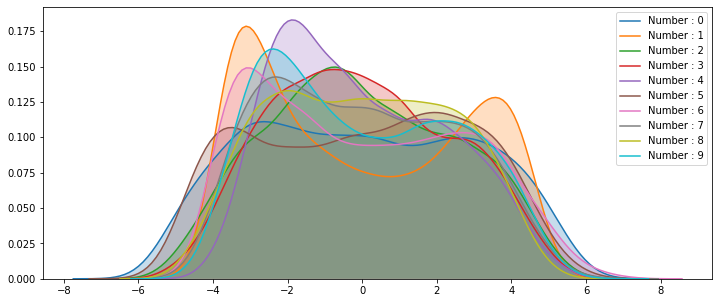

In [17]:
plt.figure(figsize=(12,5))
for number in range(10):
    data = X_data[np.where(y_data==number)]
    data = data.reshape(data.shape[0],784)/255
    pca = PCA(1)
    data = pca.fit_transform(data)
    data = data.reshape(-1,)
    sns.kdeplot(data, shade=True, label=f'Number : {number}')
plt.show()

The distribution of number 1 is most interesting, take it my our assignment

In [18]:
plt.figure(figsize=(12,5))
number = 1
data = X_data[np.where(y_data==number)]
data = data.reshape(data.shape[0],784)/255
pca = PCA(1)
data = pca.fit_transform(data)
data = data.reshape(-1,)

<Figure size 864x360 with 0 Axes>

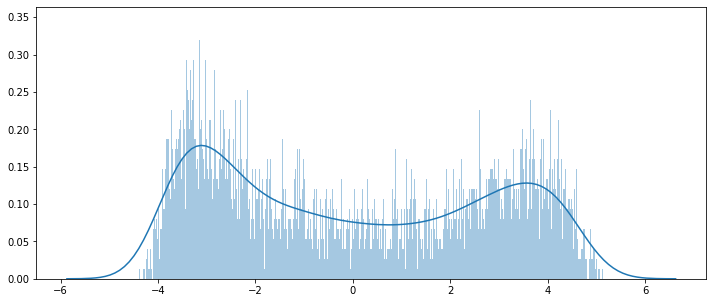

In [19]:
plt.figure(figsize=(12,5))
sns.distplot(data, bins=1000)

# Implement a class like the case of sklearn's KDE

In [0]:
def gaussian(x,b=1):
    return np.exp(-x**2/(2*b**2))/(b*np.sqrt(2*np.pi))

def epanechnikov_pdf(x_i, bandwidth):
    lowerb = (x_i - bandwidth)
    upperb = (x_i + bandwidth)
    def evaluate(x):
        if  x<=lowerb: pdf=0
        elif x>upperb: pdf=0
        else: pdf=(3/4*(1-((x-x_i)/bandwidth)**2))
        return(pdf)
    return(evaluate)

def quartic_pdf(x_i, bandwidth):
    lowerb = (x_i - bandwidth)
    upperb = (x_i + bandwidth)
    def evaluate(x):
        if  x<=lowerb: pdf=0
        elif x>upperb: pdf=0
        else: pdf=(15/16*(1-((x-x_i)/bandwidth)**2)**2)
        return(pdf)
    return(evaluate)

def triweight_pdf(x_i, bandwidth):
    lowerb = (x_i - bandwidth)
    upperb = (x_i + bandwidth)
    def evaluate(x):
        if  x<=lowerb: pdf=0
        elif x>upperb: pdf=0
        else: pdf=(35/32*(1-((x-x_i)/bandwidth)**2)**3)
        return(pdf)
    return(evaluate)

def cosine_pdf(x_i, bandwidth):
    lowerb = (x_i - bandwidth)
    upperb = (x_i + bandwidth)
    def evaluate(x):
        if  x<=lowerb: pdf=0
        elif x>upperb: pdf=0
        else: pdf=(np.pi)*np.cos(np.pi*(x-x_i)/2)
        return(pdf)
    return(evaluate)

def uniform_pdf(x_i, bandwidth):
    lowerb = (x_i - bandwidth)
    upperb = (x_i + bandwidth)
    def evaluate(x):
        if  x<=lowerb: pdf=0
        elif x>upperb: pdf=0
        else: pdf=(1/(2*bandwidth))
        return(pdf)
    return(evaluate)

def triangular_pdf(x_i, bandwidth):
    lowerb = (x_i - bandwidth)
    upperb = (x_i + bandwidth)
    def evaluate(x):
        """Evaluate x."""
        if  x <= lowerb: pdf=0
        elif x > upperb: pdf=0
        else: pdf = ((bandwidth-abs(x-x_i))/bandwidth)
        return (pdf)
    return (evaluate)

def gaussian_pdf(x_i, bandwidth):
    x_bar  = x_i
    def evaluate(x):
        pdf = (np.sqrt(2*np.pi*bandwidth**2)**-1) * np.exp(-((x - x_bar)**2)/(2*bandwidth**2))
        return(pdf)
    return(evaluate)

class KDE():
    def __init__(self, kernel=gaussian_pdf, bandwidth=0.3):
        self.kernel = kernel
        self.bandwidth = bandwidth

    def kde_pdf(self, data, kernel_func, bandwidth):
        kernels = dict()
        n = len(data)
        for d in data:
            kernels[d] = kernel_func(d, bandwidth)
        def evaluate(x):
            pdfs = list()
            for d in data: pdfs.append(kernels[d](x))
            return(sum(pdfs)/n)
        return(evaluate)

    def fit(self, data):
        dist = self.kde_pdf(data, self.kernel, self.bandwidth)
        self.data = data
        self.y = [dist(i) for i in np.array(data)]
    def bandwidth_estimate(self, data):
        self.data = data
        N=100 #Number of bins
        lenDataset = len(self.data)
        #normalized histogram of loaded datase
    
        hist, bins = np.histogram(data, bins=N, range=(np.min(self.data), np.max(self.data)), density=True)
        width = 0.7 * (bins[1] - bins[0])
        dx=(bins[1] - bins[0])
        center = (bins[:-1] + bins[1:]) / 2
        
        
        h_test = np.linspace(0.01, 1, 100) #h values to iterate for testing
        L = np.zeros(len(h_test))
        fhati = np.zeros(len(self.data)) #fhati
        center
        iteration=0
        for h_iter in tqdm(h_test):
            dist = np.vectorize(self.kde_pdf(data, self.kernel, h_iter))
            #find first part of equation
            for i in range(lenDataset):
                fhat = 0
                fhat+=(dist(center[:, None]-data[i])/lenDataset)[:,0]
    
            #find second part of equation for sum fhati
            for i in range (lenDataset):
                mask=np.ones(lenDataset,dtype=bool)
                mask[i]=0
                fhati[i]=np.sum(dist(data[mask]-data[i],h_iter))/(lenDataset-1)
            L[iteration]=np.sum(fhat**2)*dx-2*np.mean(fhati)
            iteration=iteration+1
        self.banwidth=h_test[np.argmin(L)]
    def generate_new_data(self, data, n_samples):
        N=100 #Number of bins
        lenDataset = len(data)
        #normalized histogram of loaded datase
        hist, bins = np.histogram(data, bins=N, range=(np.min(data), np.max(data)), density=True)
        width = 0.7 * (bins[1] - bins[0])
        dx=(bins[1] - bins[0])
        center = (bins[:-1] + bins[1:]) / 2
        i=0
        generatedData=np.zeros(n_samples)
        while i<n_samples:
            randNo=np.random.rand(1)*(np.max(data)-np.min(data))-np.absolute(np.min(data))
            if np.random.rand(1)<=np.sum((gaussian(randNo-data,self.bandwidth))/lenDataset):
                generatedData[i]=randNo
                i+=1
        
        hist2, bins2 = np.histogram(generatedData,bins=100,range=(np.min(data),np.max(data)), density=True)
        width2 = 0.7 * (bins2[1] - bins2[0])
        center2 = (bins2[:-1] + bins2[1:]) / 2

        fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20, 8), sharex=True, sharey=True,)
        ax1.set_title('Original data')
        ax1.bar(center, hist, align='center', width=width2, fc='#AAAAFF')
        ax2.set_title('Generated data')
        ax2.bar(center2, hist2, align='center', width=width2, fc='#AAAAFF')
        plt.suptitle(f'Kernel: {self.kernel.__name__}. Bandwidth: {self.bandwidth}')
        self.hist = hist
        self.hist2 = hist2
        self.dx = dx
        self.new_data = generatedData
    def evaluate(self, data, n_samples):
        self.generate_new_data(data, n_samples)
        cumulative = np.cumsum(self.hist)*self.dx               #original dataset
        cumulativeKDE_LSCV = np.cumsum(self.hist2)*self.dx      #KDE LSCV generated
        DKDE_LSCV=np.max(np.absolute(cumulative-cumulativeKDE_LSCV))
        plt.figure(figsize=(20,8))
        plt.plot(cumulative, label="Original data")
        plt.plot(cumulativeKDE_LSCV, label="KDE_LSCV generated")
        plt.legend()
        plt.text(s=f'Dmax = %.3f' % DKDE_LSCV, y=0.60, x=0.4)
        plt.title(f'Kernel: {self.kernel.__name__}. Bandwidth: {self.bandwidth}')

# Bandwidth estimation

In [0]:
kde = KDE(uniform_pdf)
kde.bandwidth_estimate(data)
kde.bandwidth

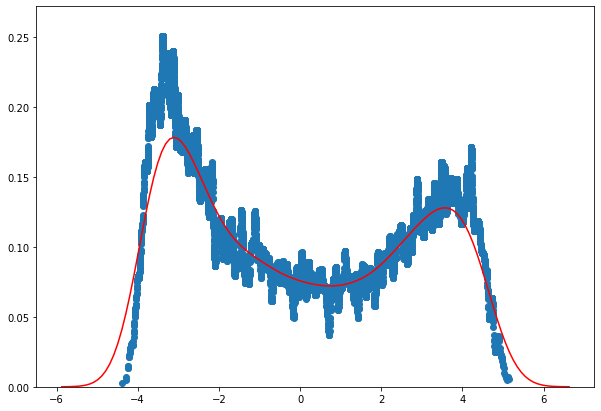

In [0]:
kde = KDE(gaussian_pdf, 0.02)
kde.fit(data)
plt.figure(figsize=(10,7))
plt.scatter(data, kde.y)
sns.kdeplot(data, color='red')
plt.show()

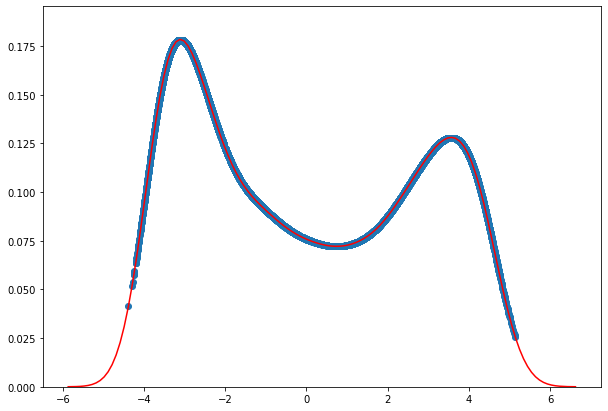

In [0]:
kde = KDE(gaussian_pdf, 0.5)
kde.fit(data)
plt.figure(figsize=(10,7))
plt.scatter(data, kde.y)
sns.kdeplot(data, color='red')
plt.show()

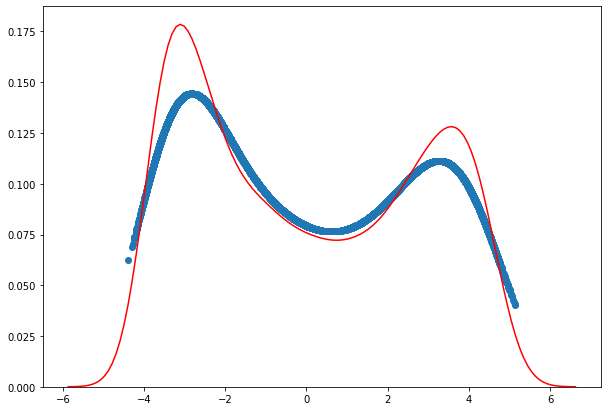

In [0]:
kde = KDE(gaussian_pdf, 0.9)
kde.fit(data)
plt.figure(figsize=(10,7))
plt.scatter(data, kde.y)
sns.kdeplot(data, color='red')
plt.show()

#  Experiments with different kernels and bandwidths

In [0]:
# Creat a parameter grid
params_grid = {'kernel':[epanechnikov_pdf, quartic_pdf, triweight_pdf, cosine_pdf, uniform_pdf, triangular_pdf, gaussian_pdf],
               'bandwidth':[0.01, 0.1, 0.3, 0.9, 1.2]}

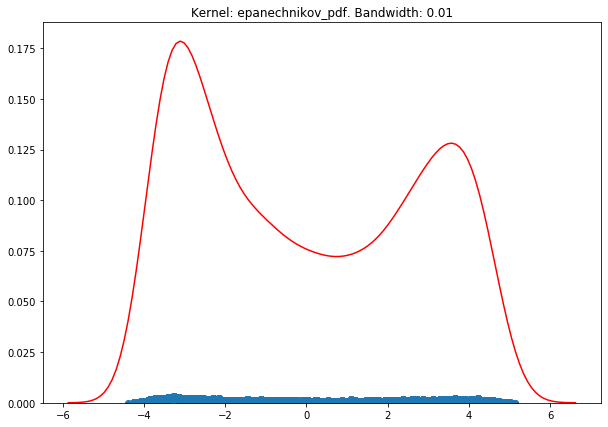

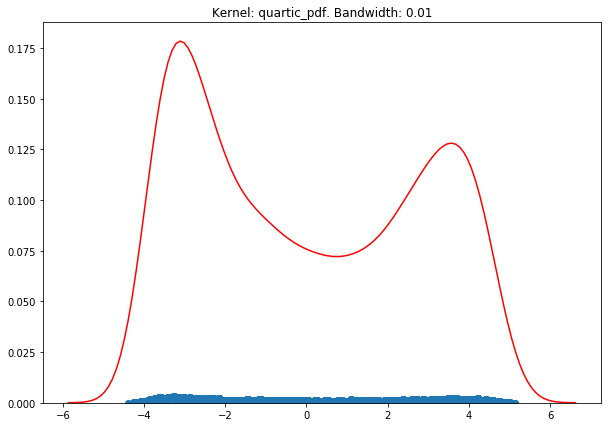

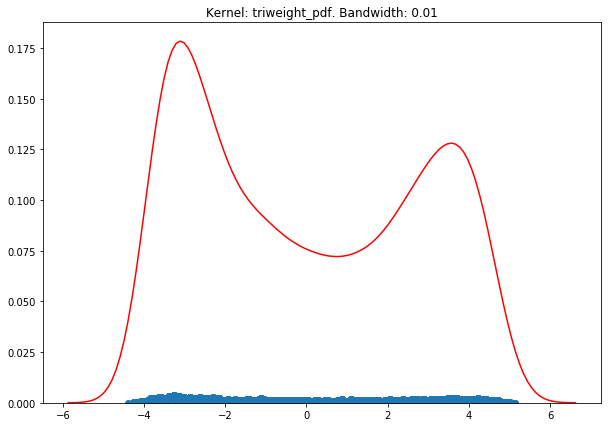

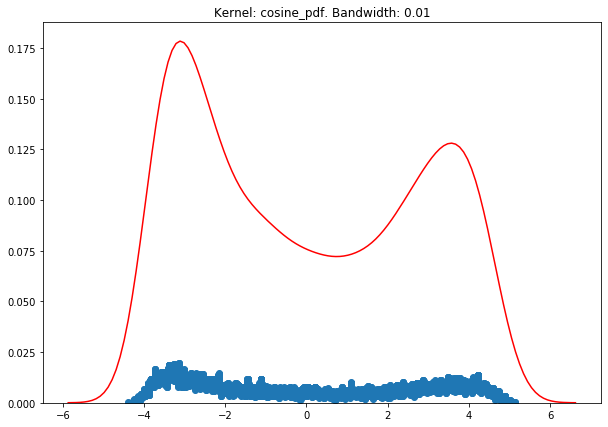

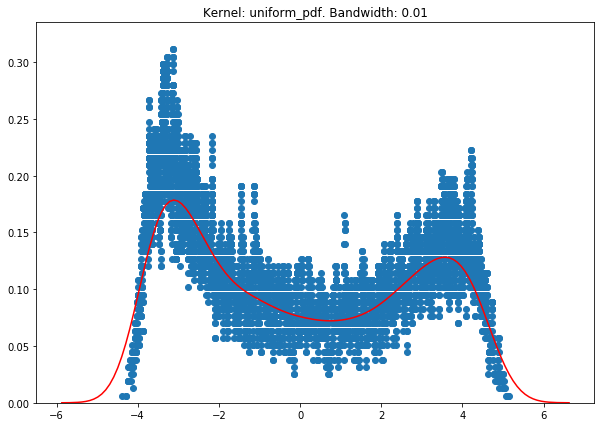

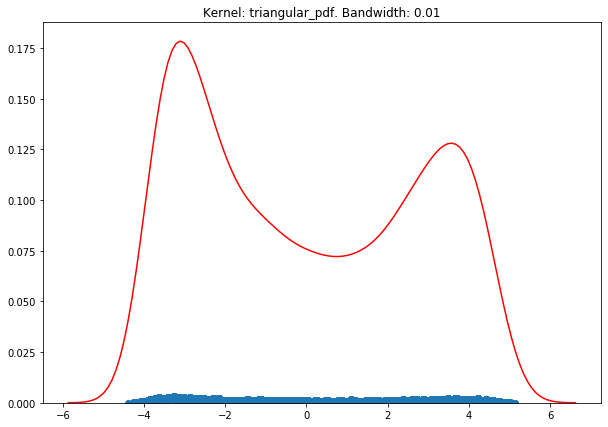

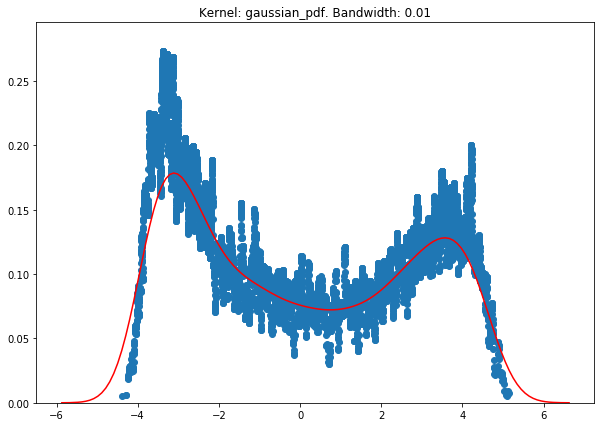

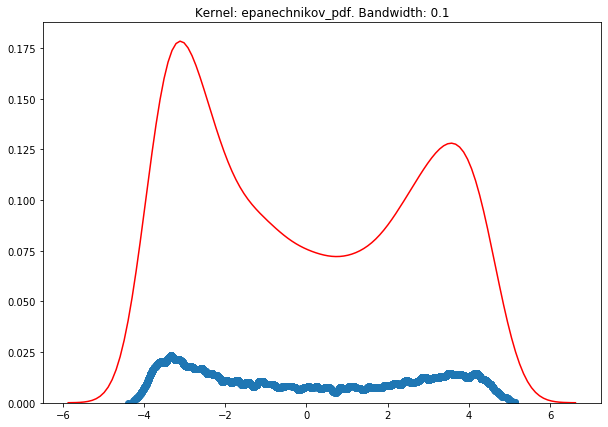

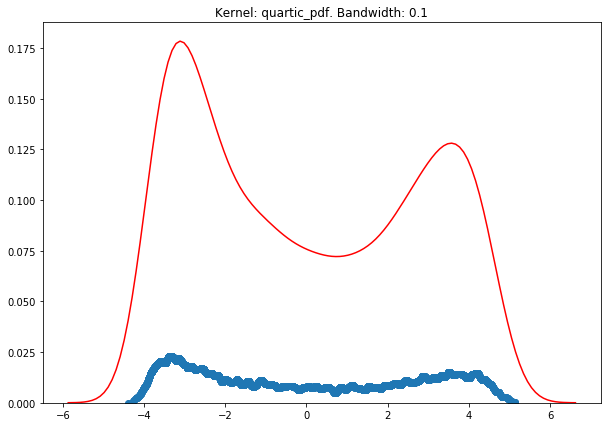

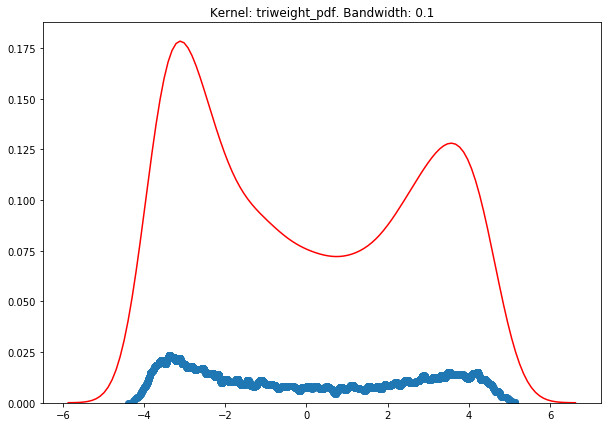

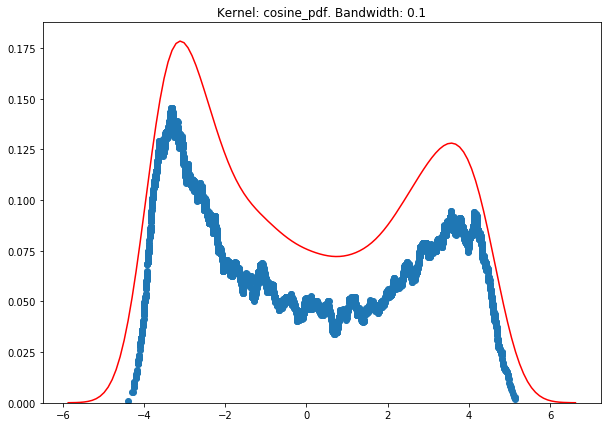

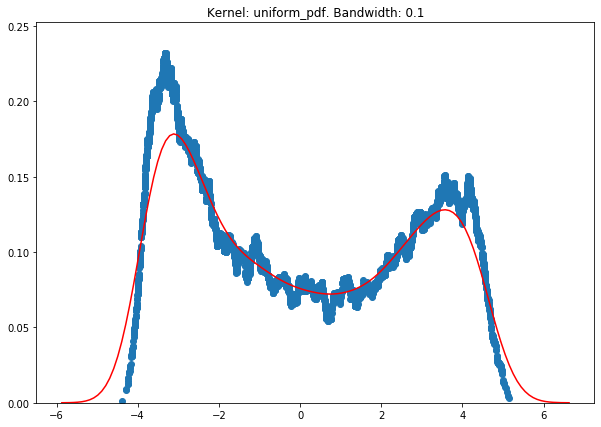

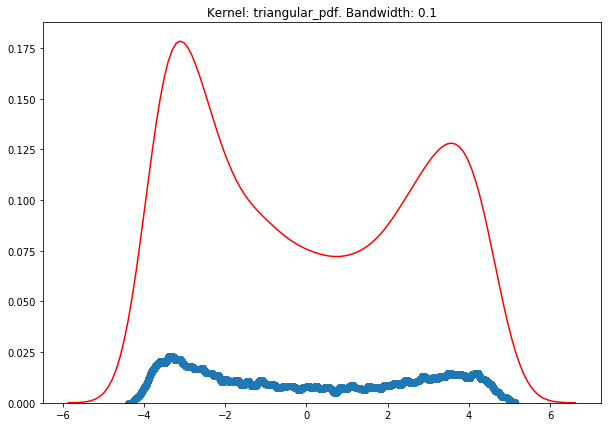

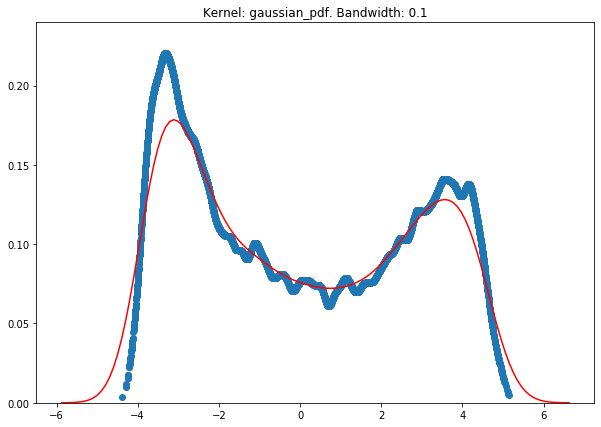

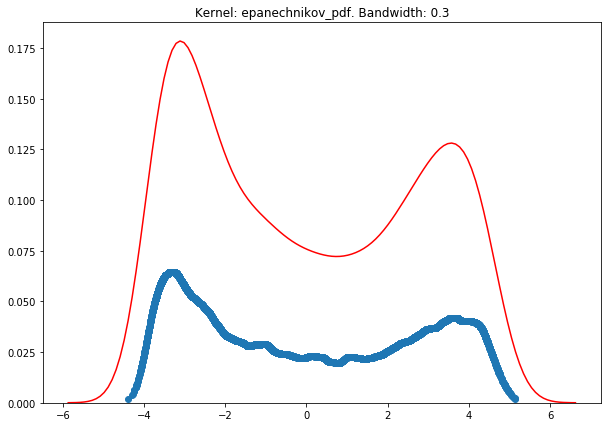

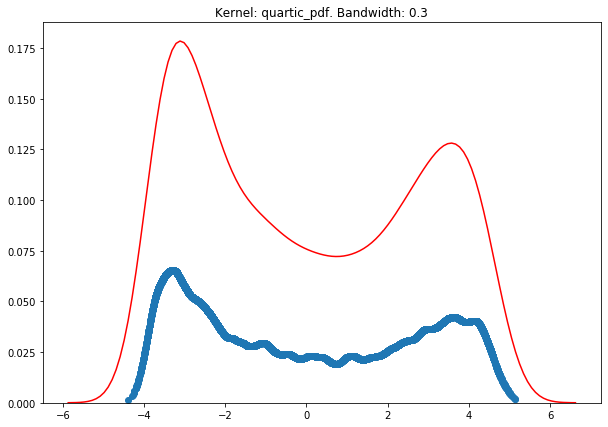

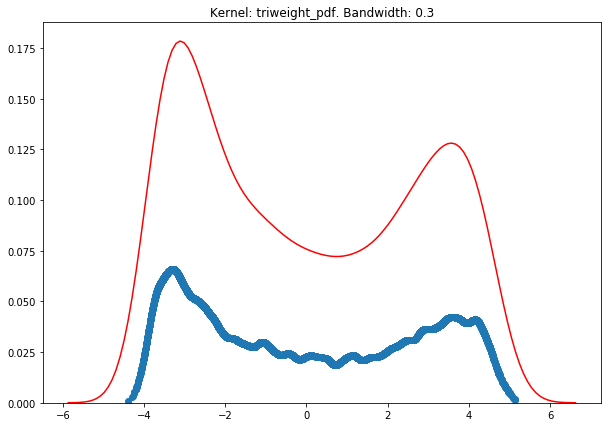

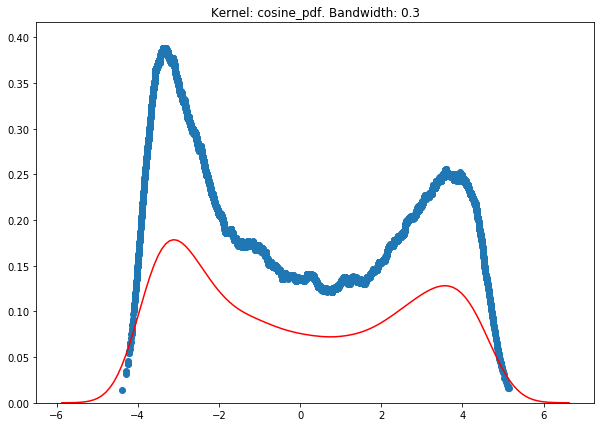

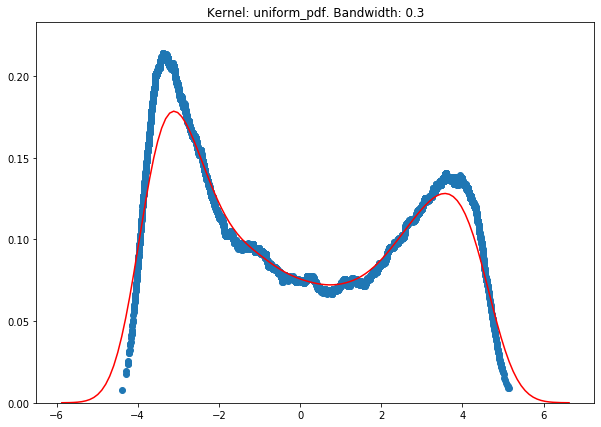

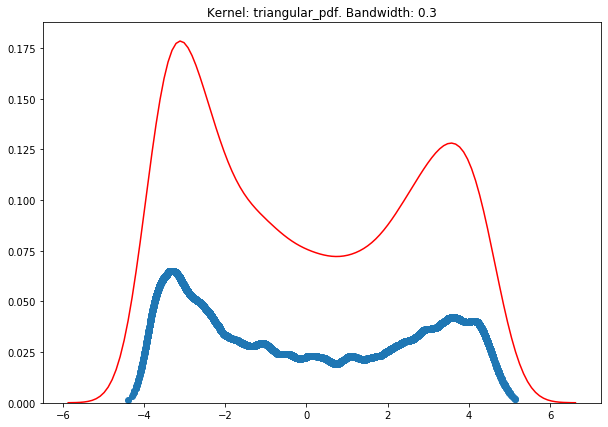

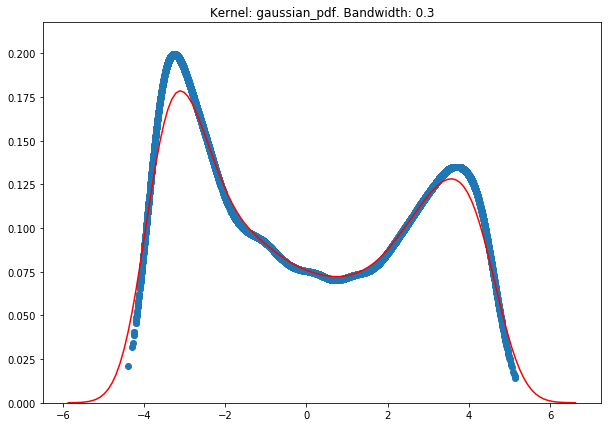

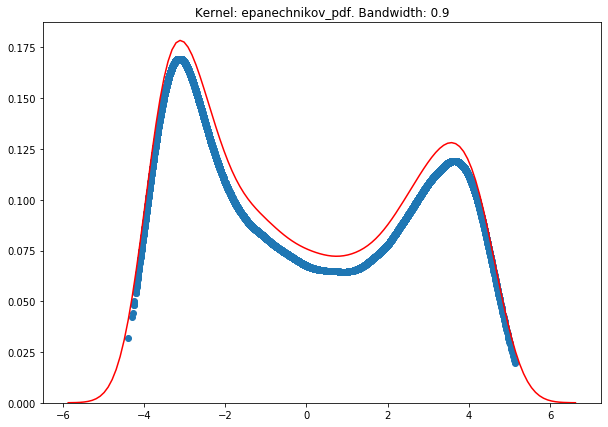

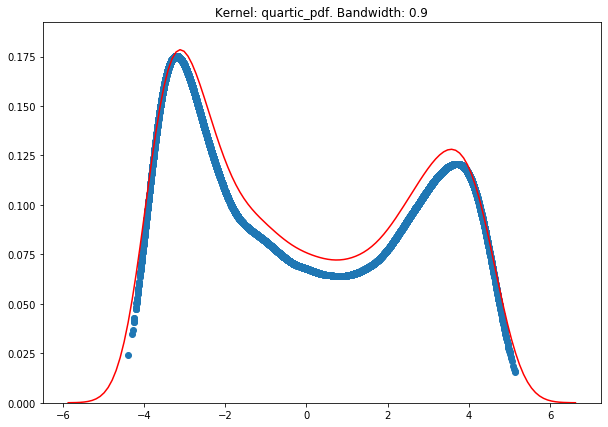

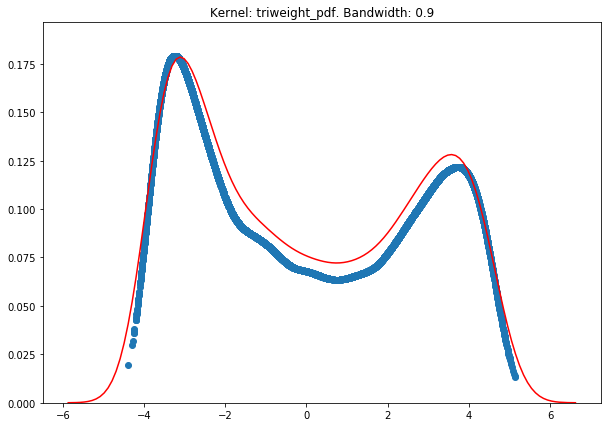

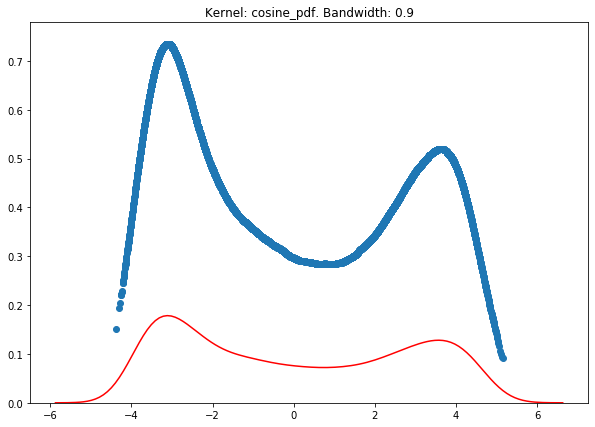

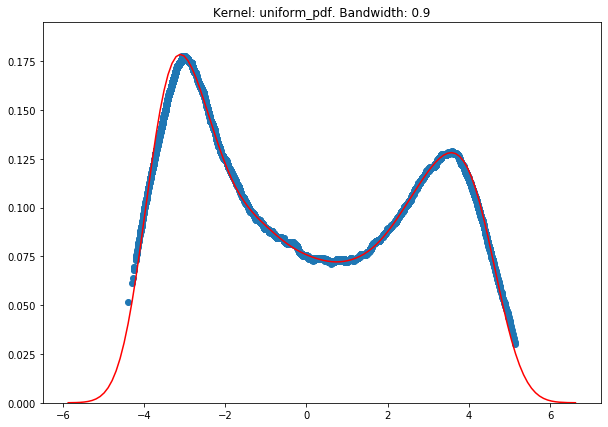

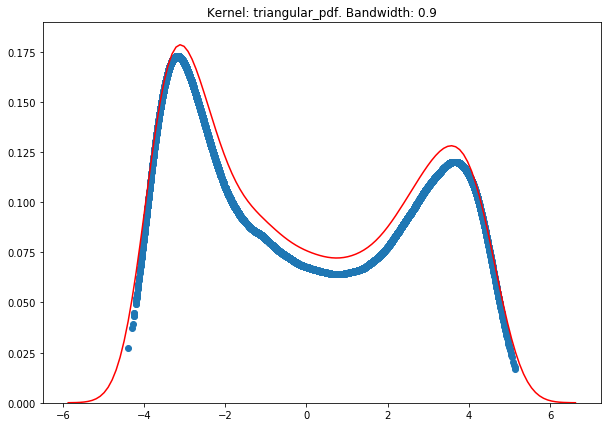

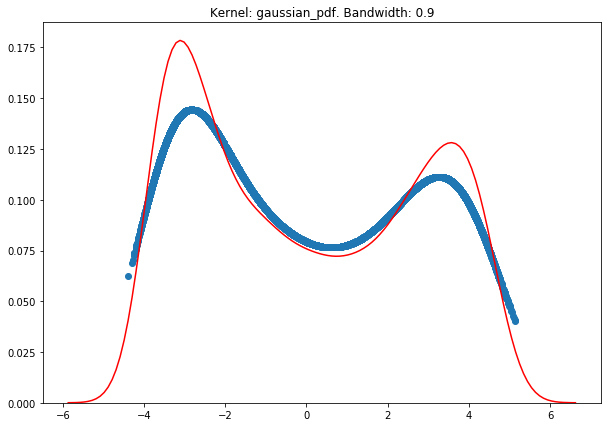

In [0]:
for params in ParameterGrid(params_grid):
    kde = KDE(**params)
    kde.fit(data)
    plt.figure(figsize=(10,7))
    plt.title(f'Kernel: {kde.kernel.__name__}. Bandwidth: {kde.bandwidth}')
    plt.scatter(data, kde.y)
    sns.kdeplot(data, color='red')
    plt.show()

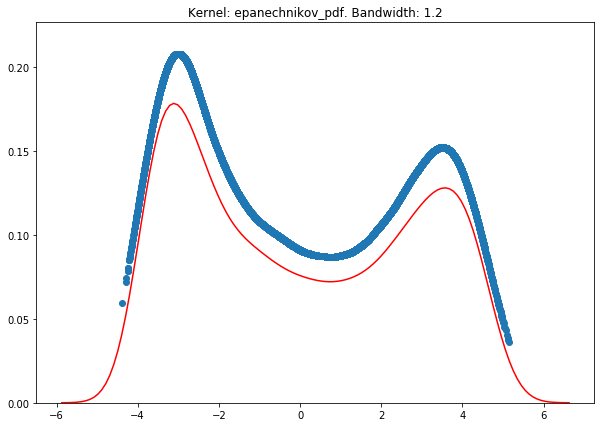

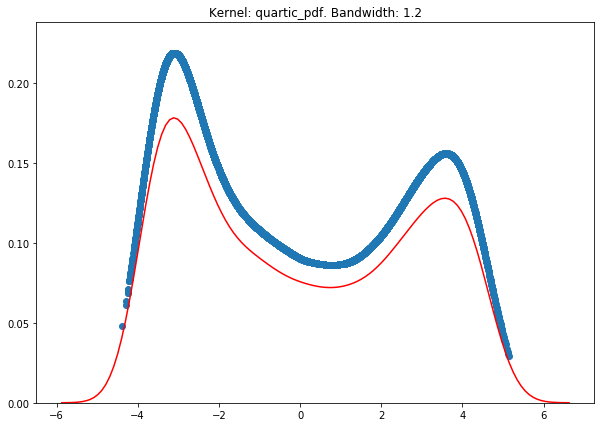

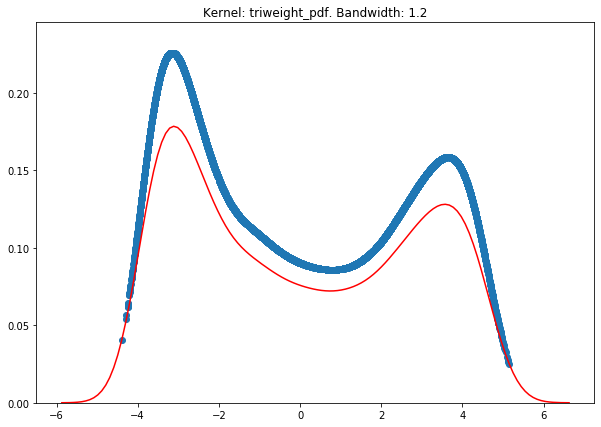

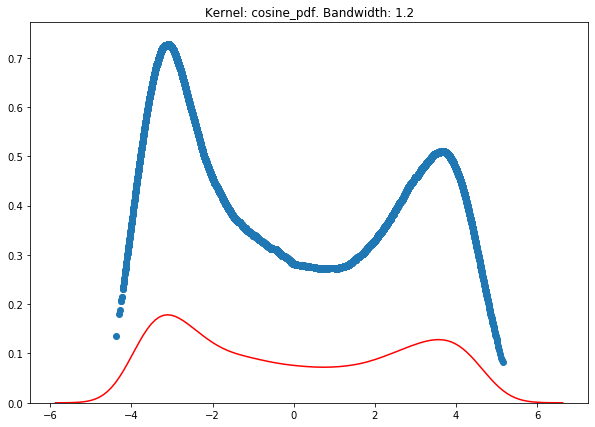

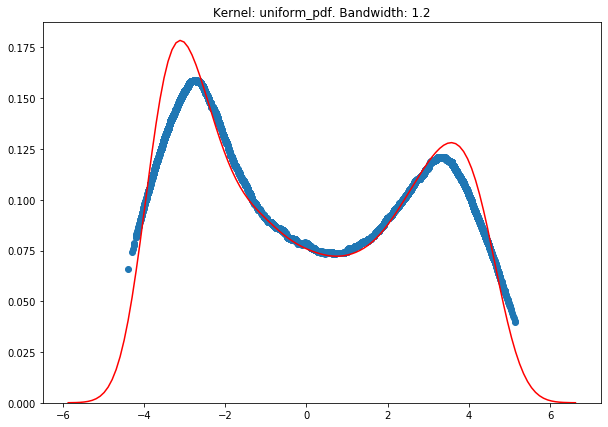

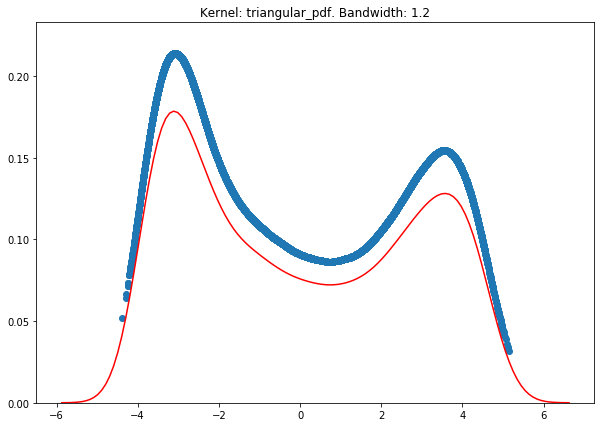

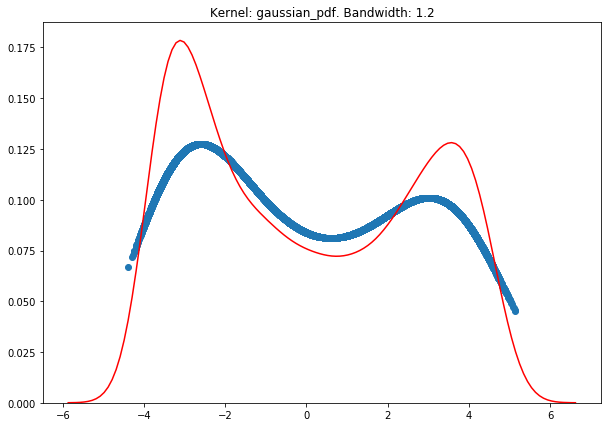

In [0]:
# one more case (bandwidth=1.2)
params_grid = {'kernel':[epanechnikov_pdf, quartic_pdf, triweight_pdf, cosine_pdf, uniform_pdf, triangular_pdf, gaussian_pdf],
               'bandwidth':[1.2]}
for params in ParameterGrid(params_grid):
    kde = KDE(**params)
    kde.fit(data)
    plt.figure(figsize=(10,7))
    plt.title(f'Kernel: {kde.kernel.__name__}. Bandwidth: {kde.bandwidth}')
    plt.scatter(data, kde.y)
    sns.kdeplot(data, color='red')
    plt.show()

# Generate new data and evaluate

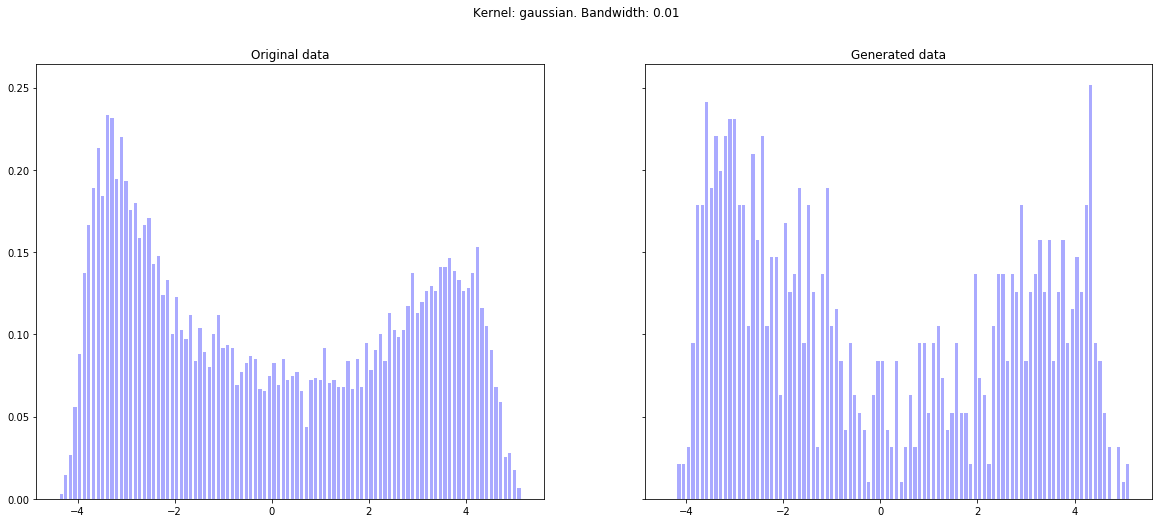

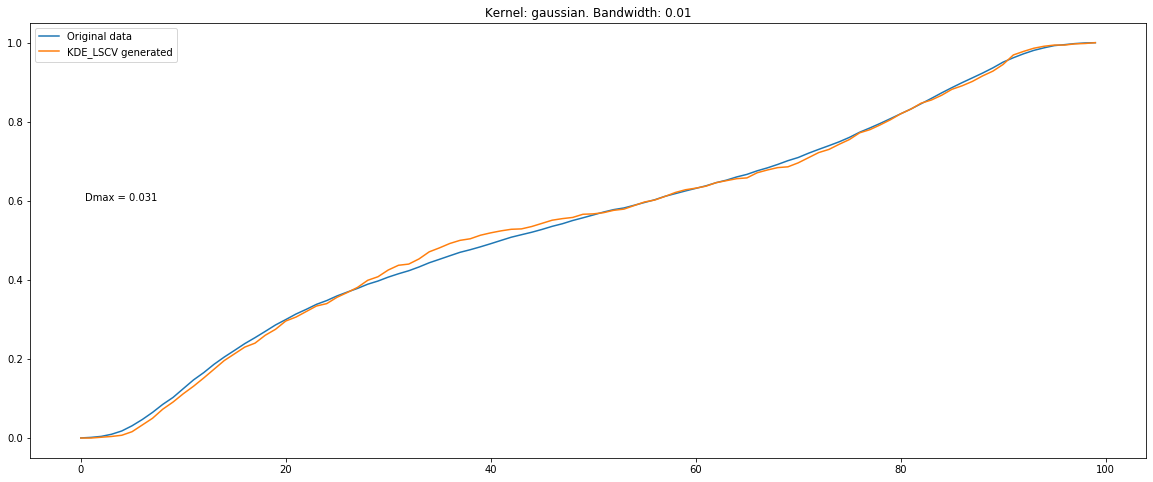

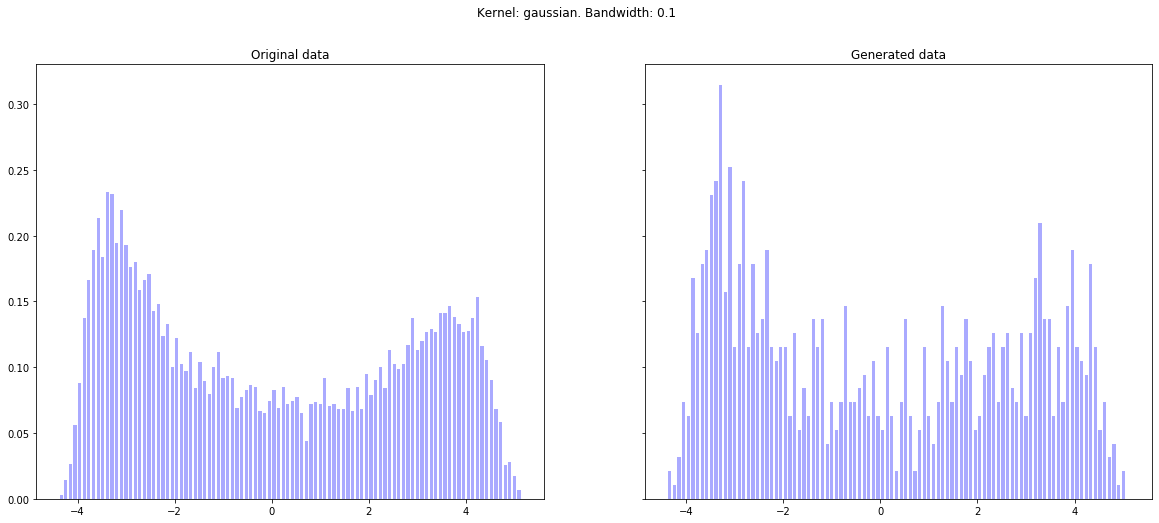

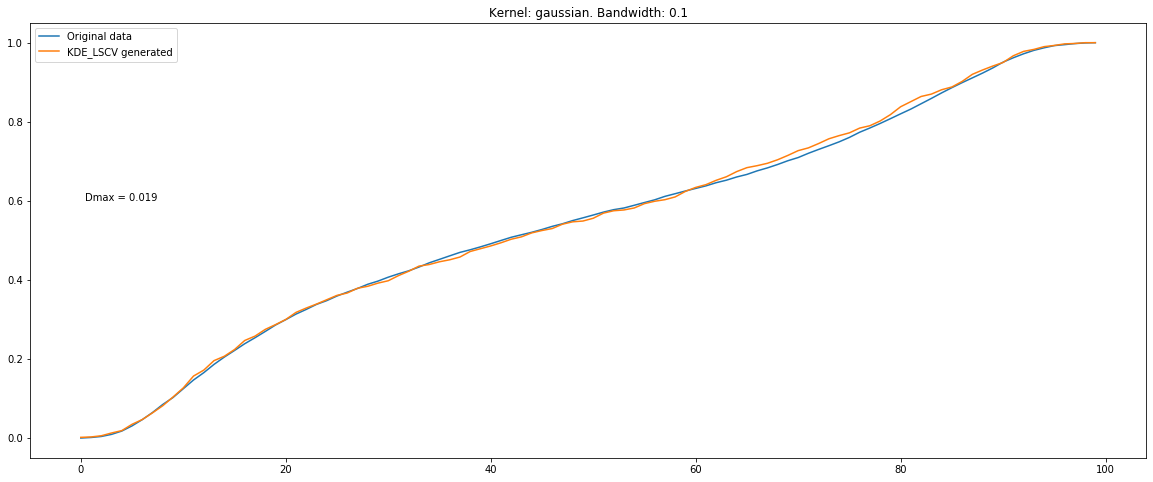

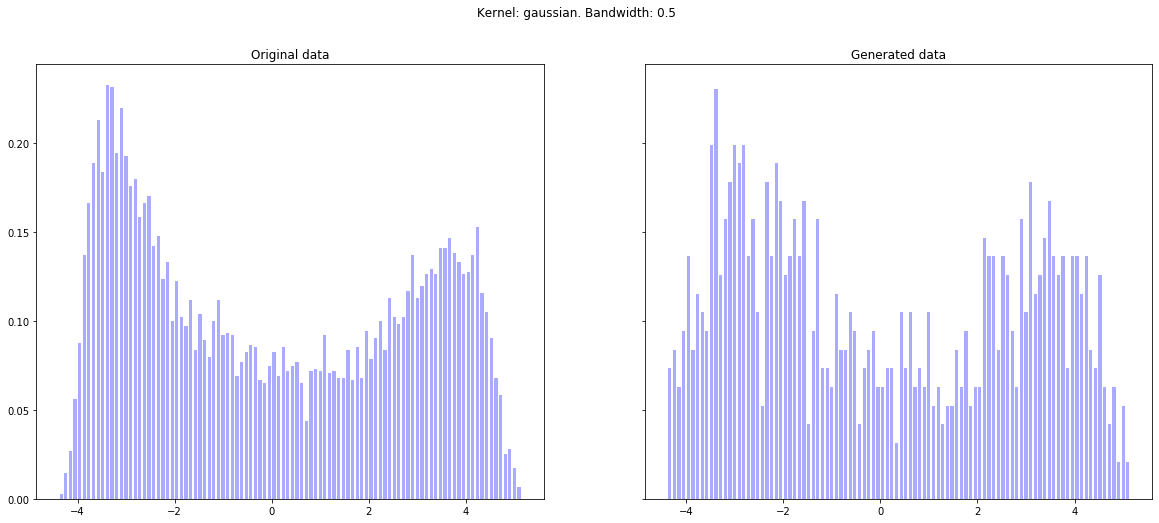

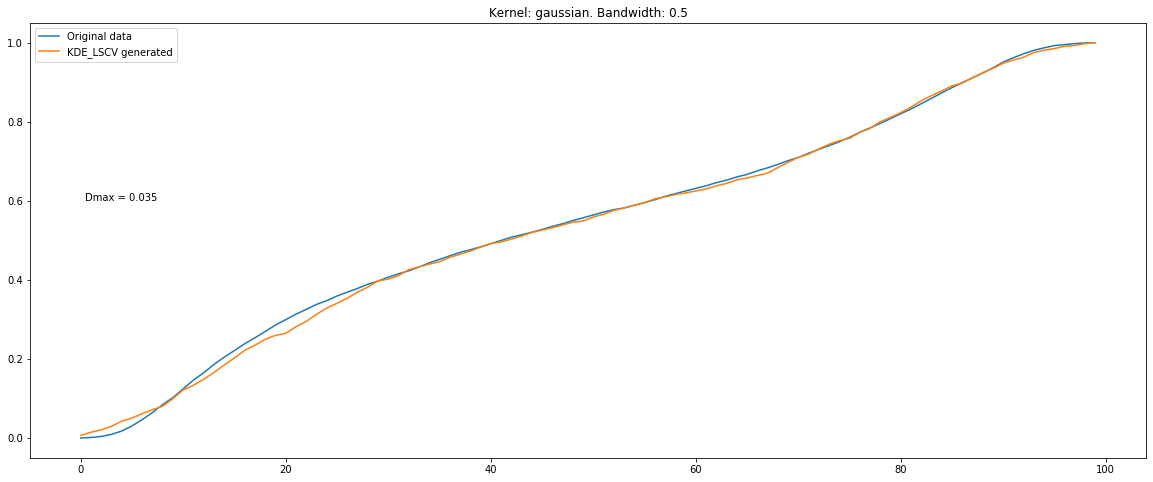

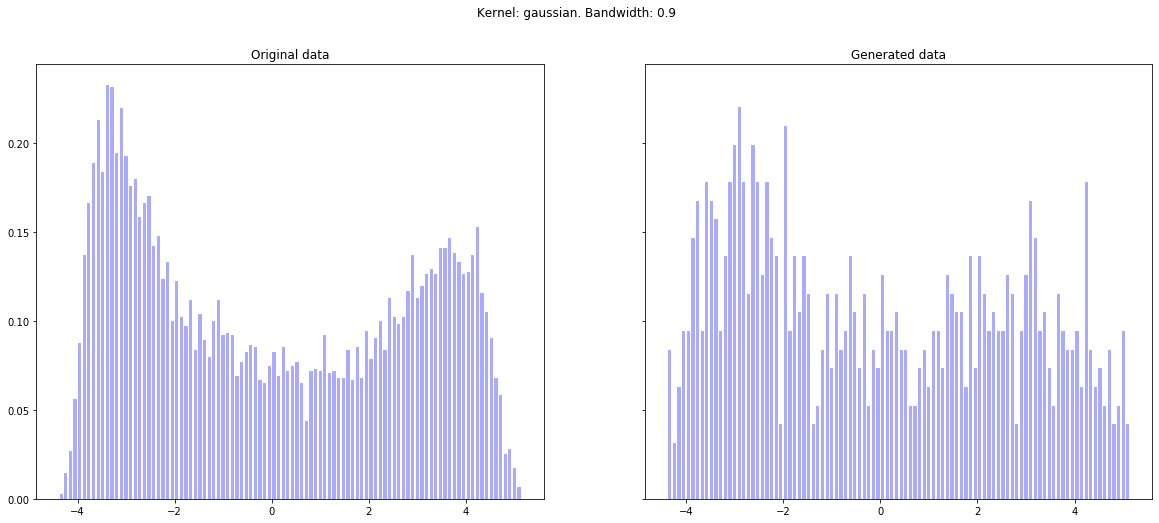

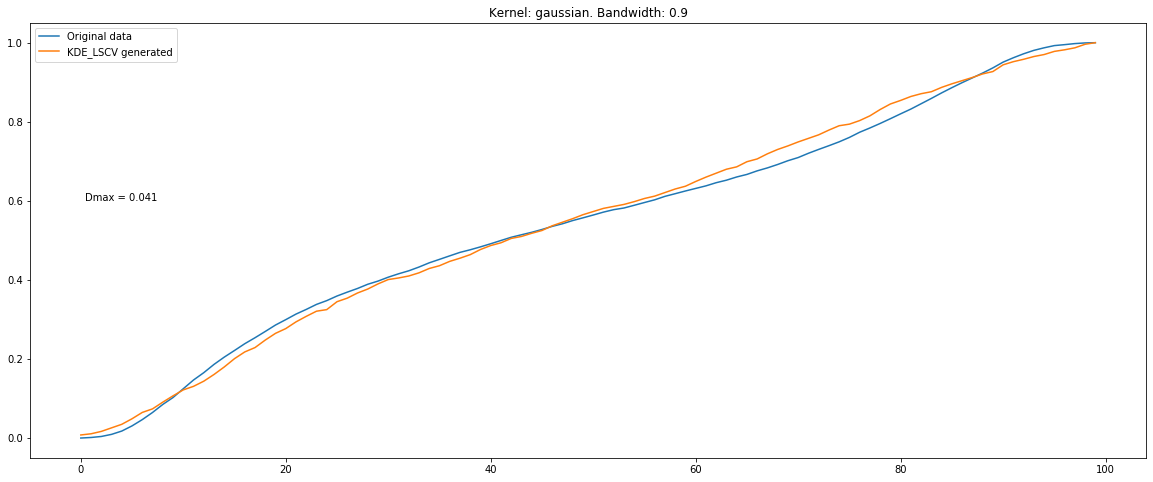

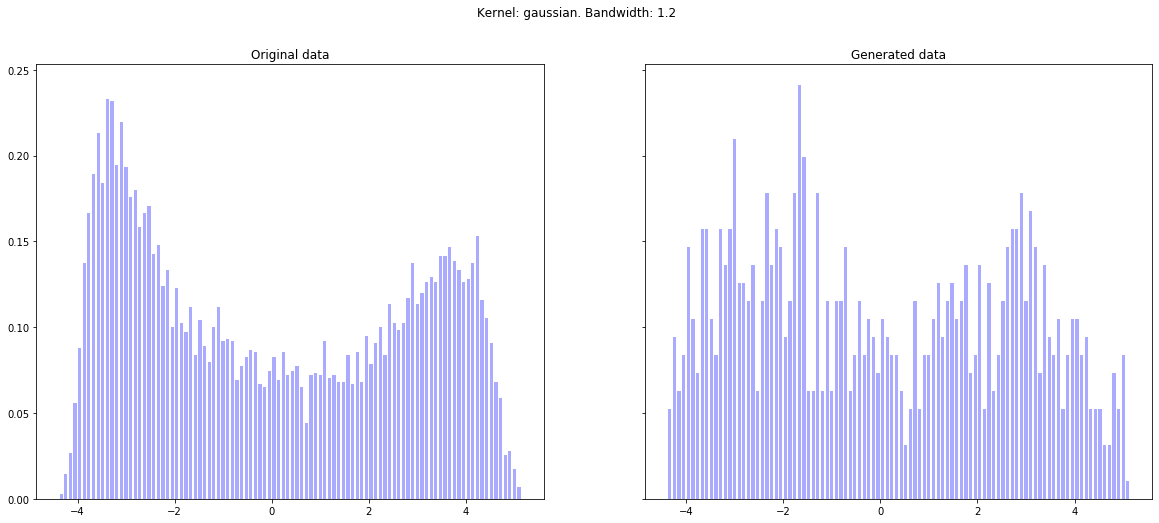

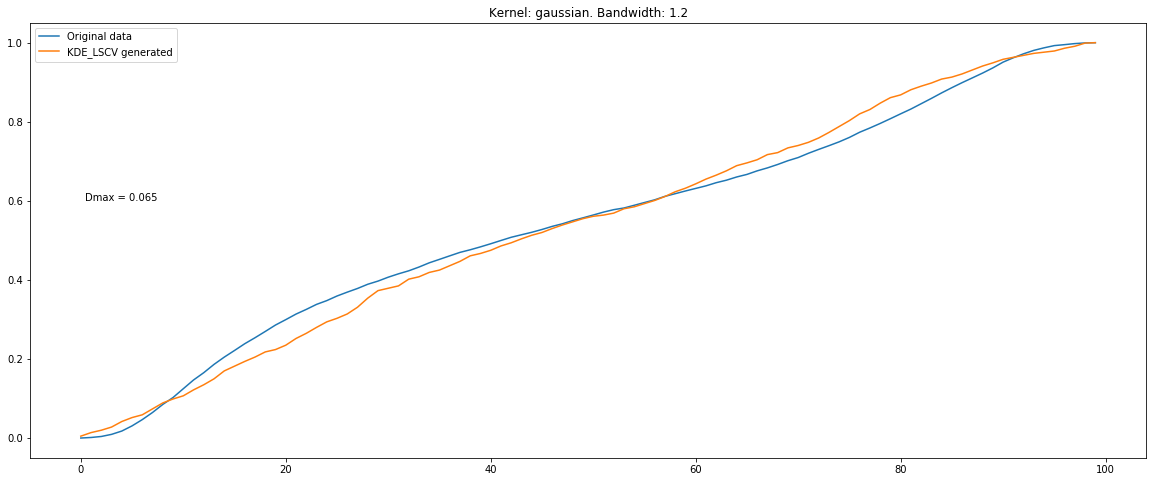

In [96]:
# Creat a parameter grid
params_grid = {'kernel':[gaussian],
               'bandwidth':[0.01,0.1, 0.5, 0.9, 1.2]}
for params in ParameterGrid(params_grid):
    kde = KDE(**params)
    kde.evaluate(data, n_samples=1000)
    plt.show()

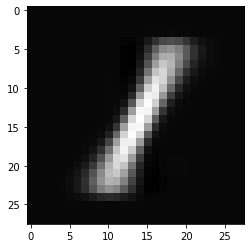

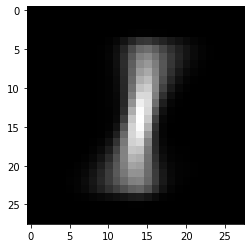

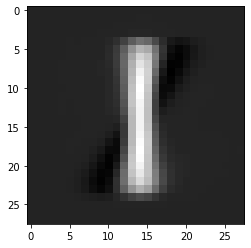

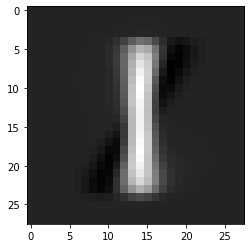

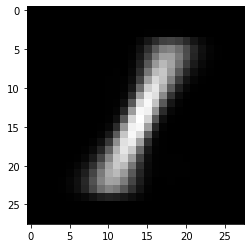

In [97]:
samples = kde.new_data[:5]
samples = samples.reshape(-1,1)
samples = pca.inverse_transform(samples)
samples = samples.reshape(samples.shape[0],28,28)

for img in samples:
    plt.imshow(img,cmap='gray')
    plt.show()